# Designing a Recommendation Model

Last updated : November 11th, 2022 

# Introduction


## 1. Data Preprocessing

We will first load and process our dataset.

### 1.1 Loading packages and the Dataset

In [1]:
#Importing packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#Setting large figure size for Seaborn
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":18})
import dill

import os
import shutil

import tensorflow as tf

import sklearn

from surprise import Reader, Dataset
from surprise.model_selection import train_test_split, cross_validate

tf.get_logger().setLevel('ERROR')

In [2]:
meta = pd.read_csv('Data/articles_metadata.csv')

meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   article_id     364047 non-null  int64
 1   category_id    364047 non-null  int64
 2   created_at_ts  364047 non-null  int64
 3   publisher_id   364047 non-null  int64
 4   words_count    364047 non-null  int64
dtypes: int64(5)
memory usage: 13.9 MB


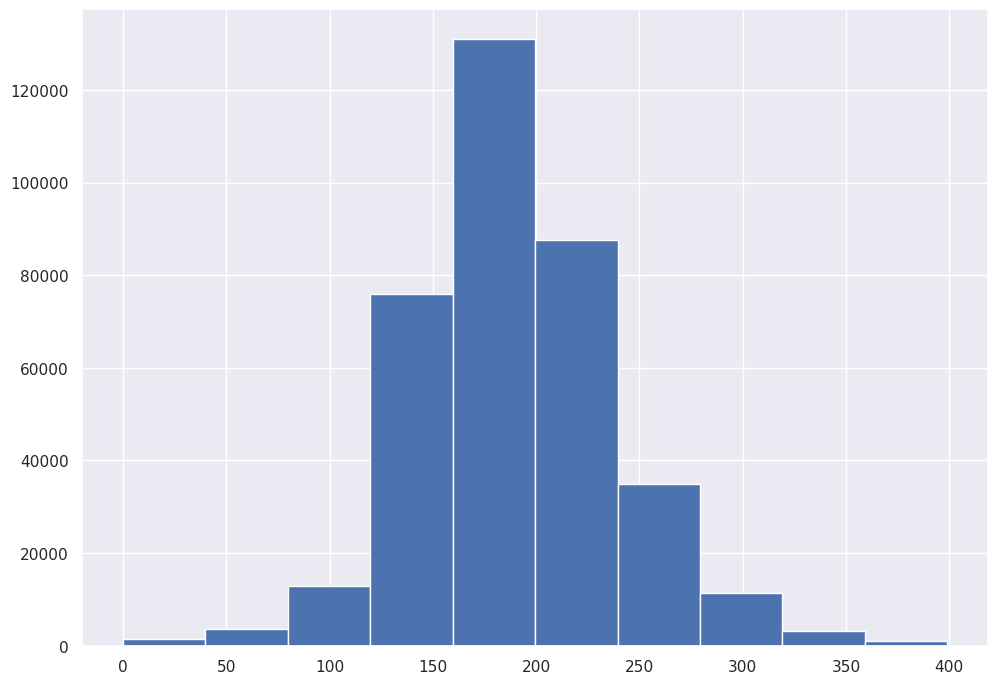

In [3]:
plt.hist(meta[meta.words_count<400].words_count)
plt.show()

In [4]:
len(meta[meta.words_count>= 400])

1218

In [5]:
print(len(meta.category_id.unique()))

meta.category_id.value_counts(normalize=True)

461


281    0.035207
375    0.027483
399    0.024857
412    0.023755
431    0.021313
         ...   
341    0.000003
121    0.000003
335    0.000003
131    0.000003
0      0.000003
Name: category_id, Length: 461, dtype: float64

In [6]:
#Testing that all article_id are unique
assert len(meta.article_id.unique()) == len(meta)

In [7]:
len(meta.publisher_id.unique())
# only 1 publisher, we can delete this column

meta.drop(columns={"publisher_id"}, inplace=True)

meta.head()

,article_id,category_id,created_at_ts,words_count
0,0,0,1513144419000,168
1,1,1,1405341936000,189
2,2,1,1408667706000,250
3,3,1,1408468313000,230
4,4,1,1407071171000,162


In [8]:
sample = pd.read_csv('Data/clicks_sample.csv')

sample.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [9]:
CLICK_PATH = 'Data/clicks/'

click_files = [CLICK_PATH + f for f in os.listdir(CLICK_PATH)]

click_files.sort()

print("Number of click files: ", len(click_files))

print("Concatenating click files...")

click_dfs = [pd.read_csv(x) for x in click_files]

click_df = pd.concat(click_dfs, axis=0, ignore_index=True)

print(click_df.shape)
click_df.head()

Number of click files:  385
Concatenating click files...
(2988181, 12)


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [10]:
#Collaborative filtering does not require data about users apart from the article they visit
cf_df = click_df.merge(meta, left_on='click_article_id', right_on='article_id', how='inner')

cf_df = cf_df[['user_id', 'article_id', 'category_id']]
print(cf_df.shape)
cf_df.head()

(2988181, 3)


,user_id,article_id,category_id
0,0,157541,281
1,20,157541,281
2,44,157541,281
3,45,157541,281
4,76,157541,281


In [11]:
#Creating user engagement matrix
engagement = cf_df.groupby(['user_id','category_id']).size().reset_index()

engagement.rename(columns={0: 'rating'}, inplace=True)

engagement.head()

,user_id,category_id,rating
0,0,136,1
1,0,186,2
2,0,209,1
3,0,281,2
4,0,375,1


In [12]:
print(engagement.rating.describe())

engagement[engagement.rating > 200]

#Some users are particularly active, but the average engagement rating is only 1.6

count    1.882302e+06
mean     1.587514e+00
std      1.921600e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      5.350000e+02
Name: rating, dtype: float64


,user_id,category_id,rating
132132,11521,398,348
172550,15275,226,211
172551,15275,228,535
179180,15867,375,256
668157,67935,428,303


In [13]:
len(engagement[engagement.rating > 10])
#Only 10 thousand users out of 1.8 million with an engagement of more than 10 on a category

10547

In [14]:
reader = Reader(rating_scale=(1,10))

X = engagement.loc[engagement.rating > 1]

df = Dataset.load_from_df(X, reader)

print("Number of interactions: ", len(X))

Number of interactions:  503616


In [15]:
#Creating test and train sets
X_train, X_test = train_test_split(df, test_size=0.1, random_state = 455, shuffle=True)

In [16]:
from surprise import SVD, accuracy

model = SVD()

model.fit(X_train)

pred = model.test(X_test)

rmse = accuracy.rmse(pred)
mae = accuracy.mae(pred)
fcp = accuracy.fcp(pred)


# print("RMSE: {:.2f}".format(rmse))
# print("MAE: {:.2f}".format(mae))
# print("FCP: {:.2f}".format(fcp))

RMSE: 8.0046
MAE:  7.1258
FCP:  0.0000


In [18]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_epochs': [5,10,20,30],
             'lr_all': [0.001, 0.002, 0.003, 0.004, 0.005, 0.01],
             'reg_all': [0.2, 0.4, 0.6, 0.8],
              'n_factors': [80,100,120,150,200]
             }

gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=5, joblib_verbose=10, n_jobs=-1)

gs.fit(df)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

3.153658495759053
{'n_epochs': 30, 'lr_all': 0.002, 'reg_all': 0.2, 'n_factors': 120}


[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 26.3min finished


In [19]:
model = SVD(n_epochs=30, lr_all=0.002, reg_all=0.2, n_factors=120)

model.fit(X_train)

pred = model.test(X_test)

rmse = accuracy.rmse(pred)
mae = accuracy.mae(pred)
fcp = accuracy.fcp(pred)


RMSE: 4.1863
MAE:  1.3269
FCP:  0.5143


In [20]:
param_grid = {'n_epochs': [30,50,70,100],
             'lr_all': [0.002],
             'reg_all': [0,0.1,0.2],
              'n_factors': [120]
             }

gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=5, joblib_verbose=10, n_jobs=-1)

gs.fit(df)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done  44 out of  60 | elapsed:  1.1min remaining:   23.5s
[Parallel(n_jobs=-1)]: Done  51 out of  60 | elapsed:  1.3min remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed:  1.5min remaining:    3.1s


3.1397736804051406
{'n_epochs': 30, 'lr_all': 0.002, 'reg_all': 0.1, 'n_factors': 120}


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.5min finished


In [21]:
model = SVD(n_epochs=30, lr_all=0.002, reg_all=0.1, n_factors=120)

model.fit(X_train)

pred = model.test(X_test)

rmse = accuracy.rmse(pred)
mae = accuracy.mae(pred)
fcp = accuracy.fcp(pred)

RMSE: 4.1770
MAE:  1.3151
FCP:  0.5205


In [23]:
from surprise import SlopeOne

model = SlopeOne()

model.fit(X_train)

pred = model.test(X_test)

rmse = accuracy.rmse(pred)
mae = accuracy.mae(pred)
fcp = accuracy.fcp(pred)

RMSE: 4.2632
MAE:  1.7197
FCP:  0.5594


In [25]:
from surprise import NMF

model = NMF()

model.fit(X_train)

pred = model.test(X_test)

rmse = accuracy.rmse(pred)
mae = accuracy.mae(pred)
fcp = accuracy.fcp(pred)

RMSE: 4.2666
MAE:  1.6161
FCP:  0.5427


In [27]:
param_grid = {'n_epochs': [20,30,50],
             'reg_pu': [0.02,0.04,0.06,0.08],
              'reg_qi': [0.02,0.04,0.06,0.08],
              'n_factors': [15,30,60,120]
             }

gs = GridSearchCV(NMF, param_grid, measures=["rmse", "fcp"], cv=3, joblib_verbose=10, n_jobs=-1)

gs.fit(df)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

3.213495937940552
{'n_epochs': 30, 'reg_pu': 0.08, 'reg_qi': 0.08, 'n_factors': 120}


[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed: 24.6min finished


In [28]:
param_grid = {'n_epochs': [30],
             'reg_pu': [0.07,0.08,0.1],
              'reg_qi': [0.07,0.08,0.1],
              'n_factors': [100,120,140,160]
             }

gs = GridSearchCV(NMF, param_grid, measures=["rmse", "fcp"], cv=3, joblib_verbose=10, n_jobs=-1)

gs.fit(df)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])
print(gs.best_score["fcp"])
print(gs.best_params["fcp"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  96 out of 108 | elapsed:  7.8min remaining:   58.6s


3.207734110335018
{'n_epochs': 30, 'reg_pu': 0.08, 'reg_qi': 0.1, 'n_factors': 160}
0.5973364808376528
{'n_epochs': 30, 'reg_pu': 0.1, 'reg_qi': 0.1, 'n_factors': 160}


[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  8.6min finished


In [29]:
param_grid = {'n_epochs': [30],
             'reg_pu': [0.1,0.12,0.14,0.17,0.2],
              'reg_qi': [0.1,0.12,0.14,0.17,0.2],
              'n_factors': [160,180,200,250,300]
             }

gs = GridSearchCV(NMF, param_grid, measures=["rmse", "fcp"], cv=3, joblib_verbose=10, n_jobs=-1)

gs.fit(df)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])
print(gs.best_score["fcp"])
print(gs.best_params["fcp"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 2

3.2080978449051347
{'n_epochs': 30, 'reg_pu': 0.1, 'reg_qi': 0.1, 'n_factors': 250}
0.606302193255142
{'n_epochs': 30, 'reg_pu': 0.17, 'reg_qi': 0.2, 'n_factors': 300}


[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed: 46.5min finished


In [30]:
model = NMF(n_epochs=30, reg_pu = 0.17, reg_qi = 0.2, n_factors=300)

model.fit(X_train)

pred = model.test(X_test)

rmse = accuracy.rmse(pred)
mae = accuracy.mae(pred)
fcp = accuracy.fcp(pred)

RMSE: 4.2173
MAE:  1.5028
FCP:  0.5531


In [31]:
model = NMF(n_epochs=30, reg_pu = 0.1, reg_qi = 0.1, n_factors=250)

model.fit(X_train)

pred = model.test(X_test)

rmse = accuracy.rmse(pred)
mae = accuracy.mae(pred)
fcp = accuracy.fcp(pred)

RMSE: 4.1977
MAE:  1.5074
FCP:  0.5492


In [40]:
from collections import defaultdict


def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_5 = get_top_n(pred, n=5)

def findRecom(dic, userId):
    res = []
    query = dic[userId]
    for uid, user_ratings in query:
        res.append(uid)
    return res

findRecom(top_5,5890)

[249, 92, 384, 126, 115]

In [38]:
pred

[Prediction(uid=46935, iid=428, r_ui=2.0, est=3.1935118057424754, details={'was_impossible': True, 'reason': 'User and item are unknown.'}),
 Prediction(uid=84616, iid=348, r_ui=2.0, est=1.6688330393527713, details={'was_impossible': False}),
 Prediction(uid=144882, iid=250, r_ui=4.0, est=1, details={'was_impossible': False}),
 Prediction(uid=7988, iid=281, r_ui=2.0, est=3.1935118057424754, details={'was_impossible': True, 'reason': 'User and item are unknown.'}),
 Prediction(uid=78974, iid=412, r_ui=4.0, est=5.055356925158371, details={'was_impossible': False}),
 Prediction(uid=81369, iid=92, r_ui=2.0, est=2.731958093172612, details={'was_impossible': False}),
 Prediction(uid=111881, iid=281, r_ui=2.0, est=2.8965404260234715, details={'was_impossible': False}),
 Prediction(uid=93942, iid=254, r_ui=2.0, est=1.5432865143542243, details={'was_impossible': False}),
 Prediction(uid=78601, iid=317, r_ui=5.0, est=1, details={'was_impossible': False}),
 Prediction(uid=34733, iid=375, r_ui=5.0

## 2. Content Based Recommendation

In [33]:
content = pd.read_pickle('Data/articles_embeddings.pickle')

print(content.shape)

(364047, 250)


In [44]:
article_list = click_df.groupby('user_id').agg(
    article_id_list = ('click_article_id', lambda x: list(x)),
)
article_list

,article_id_list
user_id,
0,"[157541, 68866, 96755, 313996, 160158, 233470,..."
1,"[235840, 96663, 59758, 160474, 285719, 156723,..."
2,"[119592, 30970, 30760, 209122]"
3,"[236065, 236294, 234686, 233769, 235665, 23513..."
4,"[48915, 44488, 195887, 195084, 63307, 336499, ..."
...,...
322892,"[42567, 39894]"
322893,"[50644, 36162]"
322894,"[36162, 168401]"


In [46]:
from tqdm.autonotebook import tqdm

tqdm.pandas()

def find_categories(article_id_list: list):
    categories = []
    for article in article_id_list:
        categories.append(meta[meta.article_id==article].category_id.values[0])
    return categories

article_list['category_list'] = article_list['article_id_list'].progress_apply(find_categories)
    

/tmp/ipykernel_421/2932728648.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/322897 [00:00<?, ?it/s]

In [65]:
category_list = article_list[['category_list']]

categories = category_list.explode('category_list').reset_index()

categories = pd.DataFrame(categories.groupby(['user_id','category_list']).size()).reset_index()

categories.rename(columns={0: 'clicks'}, inplace=True)

categories['clicks_norm'] = categories['clicks'] / categories.groupby('user_id')['clicks'].transform('max')

categories.head()

,user_id,category_list,clicks,clicks_norm
0,0,136,1,0.5
1,0,186,2,1.0
2,0,209,1,0.5
3,0,281,2,1.0
4,0,375,1,0.5


In [67]:
articles_categ = meta.loc[:, ['article_id', 'category_id']]

articles_categ

,article_id,category_id
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
364042,364042,460
364043,364043,460
364044,364044,460
364045,364045,460


user_id  category_list
0        136              1
         186              2
         209              1
         281              2
         375              1
                         ..
322894   297              1
322895   133              1
         418              1
322896   26               1
         281              1
Length: 1882302, dtype: int64

In [42]:
titles = meta['article_id']
indices = pd.Series(meta.index, index=meta['article_id'])


def inputUserRatings(userId):
    _matrix = pd.DataFrame(columns=['click'])
    _row = df.loc[userId]['categories']
    _row = _row.replace('[', '').replace(']', '').replace(',', '').split()
    
    for index, val in pd.Series(_row).value_counts().items():
        _matrix.loc[index] = int(val)
         
    _matrix['click_norm'] = _matrix.apply(lambda x : x / _matrix['click'].max())
    _matrix = _matrix.reset_index()
    _matrix = _matrix.rename(columns={"index": "category_id"})
    _matrix['category_id'] = _matrix['category_id'].astype(int)
    
    return _matrix

def simScores(title):
    idx = indices[title]
    sim_scores = list(enumerate(content[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    
    return sim_scores
    print(sim_scores)

def predictWSimScores(userId):
    _input_user_ratings = inputUserRatings(userId)
    _result = []
    for index, row in _input_user_ratings.iterrows():
        _x = simScores(row.category_id)
        for i in range(1, row.click + 1):
            _result = _result + _x
    return _result

test = predictWSimScores(5890)


AttributeError: 'DatasetAutoFolds' object has no attribute 'loc'